In [5]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import random
import xgboost as xgb
import os
import re
import pydotplus
# import statsmodels.api as sm
import pylab as pl
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix,mean_absolute_error,mean_squared_error,r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection,metrics
from sklearn.metrics import log_loss
from sklearn import tree
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
# os.environ["PATH"] += os.pathsep + 'D:\\Program Files\\Graphviz2.38\\bin'

In [6]:
raw_data = pd.read_excel(r'./data/raw_data.xlsx',index_col=0)

x = raw_data.drop(columns=['日剂量'])
y = raw_data[['日剂量']]

# load models

In [50]:
from math import sqrt
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.metrics import balanced_accuracy_score
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor

In [282]:
saving_path_name = r"./model/tabnet_model_210628.dill.zip" 

loaded_clf = TabNetRegressor(seed=0)
loaded_clf.load_model(saving_path_name)

models = []
with open(r"./model/models.pckl", "rb") as f:
    while True:
        try:
            models.append(pickle.load(f))
        except EOFError:
            break
            
models.append(loaded_clf)

Device used : cpu
Device used : cpu
[18:57:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [286]:
model_list = ['XGBoost','LightGBM','GBDT','RF','SVR','KNN','Linear','Lasso','Ridge','TabNet']
models_dict = dict(zip(model_list,models))
result_r2 = {}
result_mae = {}
result_mse = {}
result_rmse = {}
result_r2_train = {}
test_acc = {}
train_acc = {}
test_acc_3 = {}
test_acc_4 = {}
test_acc_low = {}
test_acc_high = {}
for i in model_list:
    result_r2[i] = []
    result_mae[i] = []
    result_mse[i] = []
    result_rmse[i] = []
    result_r2_train[i] = []
    test_acc[i] = []
    test_acc_3[i] = []
    test_acc_4[i] = []
    train_acc[i] = []
    test_acc_low[i] = []
    test_acc_high[i] = []

kf = KFold(n_splits=5, random_state=2021, shuffle=True)
for i, (train_index, test_index) in enumerate(kf.split(x, y)):
    train_x, test_x = x.iloc[train_index], x.iloc[test_index]
    train_y, test_y = y.iloc[train_index], y.iloc[test_index]
    
    train_x_tab, train_y_tab = train_x.values, train_y['日剂量'].values.reshape(-1,1)
    test_x_tab, test_y_tab = test_x.values, test_y['日剂量'].values.reshape(-1,1)
    
    for k,m in models_dict.items():
                     
        if k=='LightGBM':
            model = m.fit(train_x.values,train_y.values)
            pred = model.predict(test_x.values)
            pred_train = model.predict(train_x.values)
            
        elif k=='TabNet':
            pred = m.predict(test_x_tab)
            pred_train = m.predict(train_x_tab)
            
            test_y = test_y_tab
            train_y = train_y_tab
        
        else:
            model = m.fit(train_x,train_y)
            pred = model.predict(test_x)
            pred_train = model.predict(train_x)
        
        result_r2[k].append(r2_score(test_y,pred))
        result_mae[k].append(mean_absolute_error(test_y,pred))
        result_mse[k].append(mean_squared_error(test_y,pred))
        result_rmse[k].append(sqrt(mean_squared_error(test_y,pred)))
        result_r2_train[k].append(r2_score(train_y,pred_train))
        
        test_x['日剂量'], test_x['预测值'], = test_y, pred
        test_x['日剂量预测准确率'] = (test_x['预测值'] - test_x['日剂量']) / test_x['日剂量']
        test_x['日剂量预测准确率_abs'] = test_x['日剂量预测准确率'].apply(lambda x:1 if abs(x)<=0.2 else 0)
        test_x['日剂量预测准确率_abs30'] = test_x['日剂量预测准确率'].apply(lambda x:1 if abs(x)<=0.3 else 0)
        test_x['日剂量预测准确率_abs40'] = test_x['日剂量预测准确率'].apply(lambda x:1 if abs(x)<=0.4 else 0)
        test_x['日剂量预测准确率_high'] = test_x['日剂量预测准确率'].apply(lambda x:1 if x>0.2 else 0)
        test_x['日剂量预测准确率_low'] = test_x['日剂量预测准确率'].apply(lambda x:1 if x<-0.2 else 0)
        test_acc[k].append(round(test_x[test_x['日剂量预测准确率_abs']==1].shape[0] / test_x.shape[0],4))
        test_acc_3[k].append(round(test_x[test_x['日剂量预测准确率_abs30']==1].shape[0] / test_x.shape[0],4))
        test_acc_4[k].append(round(test_x[test_x['日剂量预测准确率_abs40']==1].shape[0] / test_x.shape[0],4))
        test_acc_high[k].append(round(test_x[test_x['日剂量预测准确率_high']==1].shape[0] / test_x.shape[0],4))
        test_acc_low[k].append(round(test_x[test_x['日剂量预测准确率_low']==1].shape[0] / test_x.shape[0],4))
        
        train_x['日剂量_train'], train_x['预测值_train'] = train_y, pred_train
        train_x['日剂量预测准确率_train'] = (train_x['预测值_train'] - train_x['日剂量_train']) / train_x['日剂量_train']
        train_x['日剂量预测准确率_train'] = train_x['日剂量预测准确率_train'].apply(lambda x:1 if abs(x)<=0.2 else 0)
        train_acc[k].append(round(train_x[train_x['日剂量预测准确率_train']==1].shape[0] / train_x.shape[0],4))
        test_x = test_x.drop(columns=['日剂量','预测值','日剂量预测准确率','日剂量预测准确率_abs','日剂量预测准确率_high','日剂量预测准确率_low','日剂量预测准确率_abs30','日剂量预测准确率_abs40'])
        train_x = train_x.drop(columns=['日剂量_train','预测值_train','日剂量预测准确率_train'])

[18:57:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:57:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [300]:
result_df = pd.DataFrame(data={"model":model_list,
                               "r2_score": [np.mean(v) for v in result_r2.values()],
                               "mae": [np.mean(v) for v in result_mae.values()],
                               "mse": [np.mean(v) for v in result_mse.values()],
                               "rmse": [np.mean(v) for v in result_rmse.values()],
                               "test acc_-20%":[np.mean(v)*100 for v in test_acc_low.values()],
                               "test acc_+20%":[np.mean(v)*100 for v in test_acc_high.values()]})

In [293]:
result_acc = pd.DataFrame(data={"model":model_list,
                               "test acc_20%":[np.mean(v)*100 for v in test_acc.values()],
                               "test acc_30%":[np.mean(v)*100 for v in test_acc_3.values()],
                               "test acc_40%":[np.mean(v)*100 for v in test_acc_4.values()],
                               "r2_score train":[np.mean(v) for v in result_r2_train.values()],
                               "train acc_20%":[np.mean(v)*100 for v in train_acc.values()]})

In [301]:
result_df

,model,r2_score,mae,mse,rmse,test acc_-20%,test acc_+20%
0,XGBoost,0.785769,0.488192,0.680759,0.821139,4.602,11.510
1,LightGBM,0.760093,0.523496,0.761491,0.868257,7.214,10.970
2,GBDT,0.568556,0.923150,1.367929,1.168648,7.750,25.280
3,RF,0.781948,0.460662,0.692662,0.828360,4.912,11.088
4,SVR,0.419395,1.010071,1.829072,1.342671,31.340,14.116
5,KNN,0.252562,1.240720,2.364507,1.536850,20.560,31.684
6,Linear,0.650441,0.756366,1.109593,1.050163,12.276,19.640
7,Lasso,0.650849,0.756454,1.108211,1.049608,12.504,20.022
8,Ridge,0.650441,0.756366,1.109592,1.050163,12.276,19.640
9,TabNet,0.824196,0.467780,0.557697,0.745052,5.294,8.516


In [295]:
result_acc

,model,test acc_20%,test acc_30%,test acc_40%,r2_score train,train acc_20%
0,XGBoost,83.888,89.374,92.406,0.849059,86.038
1,LightGBM,81.816,88.608,91.868,0.996997,99.434
2,GBDT,66.972,75.870,81.242,0.575940,67.062
3,RF,84.006,89.488,92.364,0.969452,94.378
4,SVR,54.544,71.114,83.352,0.458758,55.686
5,KNN,47.756,64.866,75.184,0.304909,49.952
6,Linear,68.084,80.512,86.074,0.661733,68.488
7,Lasso,67.472,80.588,86.034,0.660989,68.114
8,Ridge,68.084,80.512,86.074,0.661733,68.488
9,TabNet,86.190,91.330,93.480,0.824241,86.192


# bar graph

In [302]:
from matplotlib import pyplot as plt;  plt.style.use('seaborn')
from pylab import mpl  
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

import matplotlib.ticker as ticker
from matplotlib import rc
rc('mathtext', default='regular')

plt.rcParams['savefig.dpi'] = 600
plt.rcParams['figure.dpi'] = 600 

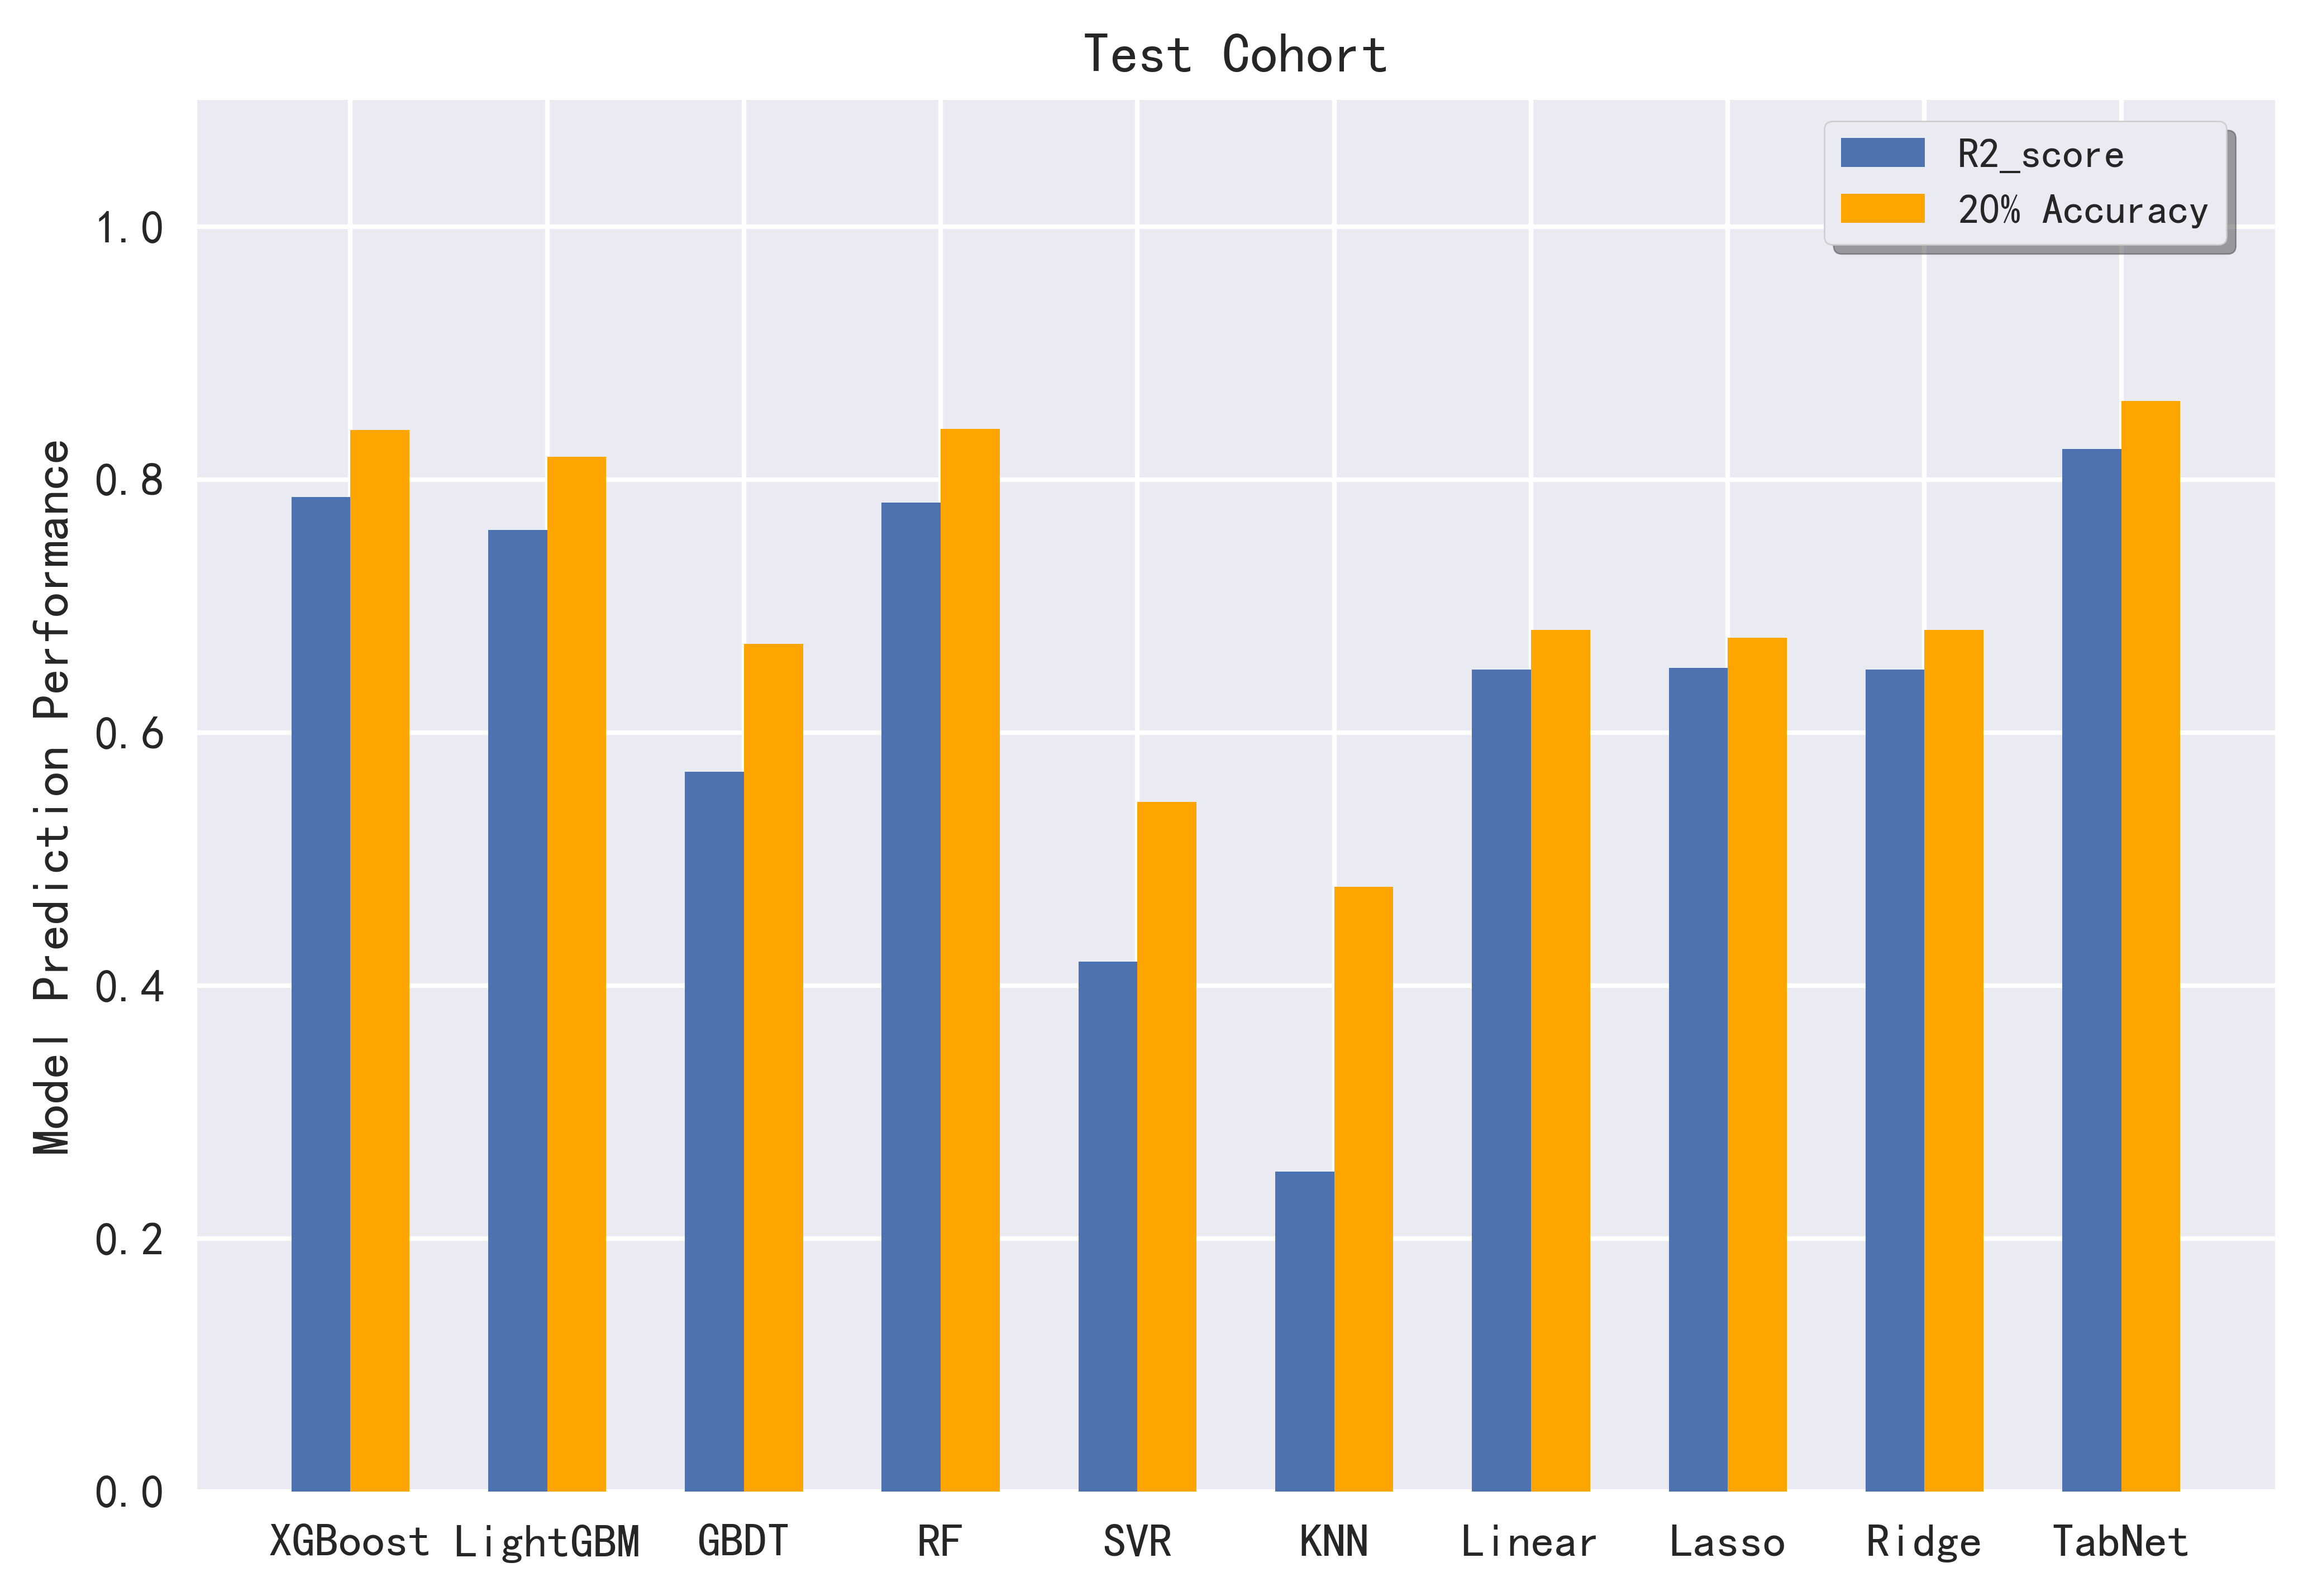

In [304]:
R2_l = [round(np.mean(v),3) for v in result_r2.values()]
per20_l = [round(np.mean(v),3) for v in test_acc.values()]
 
bar_width = 0.3
index_R2 = np.arange(len(model_list)) 
index_per20 = index_R2 + bar_width 
 
plt.bar(index_R2, height=R2_l, width=bar_width, label='R2_score')
plt.bar(index_per20, height=per20_l, width=bar_width, label='20% Accuracy',color='orange')
 
plt.legend() 
plt.legend(loc='upper center', frameon='True',  bbox_to_anchor=(0.88,1.0), markerfirst=True, shadow='True', fontsize=9)
plt.xticks((index_R2 + index_per20)/2, model_list)
plt.ylim(0, 1.1)
plt.ylabel('Model Prediction Performance') 
plt.title('Test Cohort')

# model_fig = plt.gcf()
# model_fig.savefig(r'./picture/model_performance_train.png') 
plt.show()

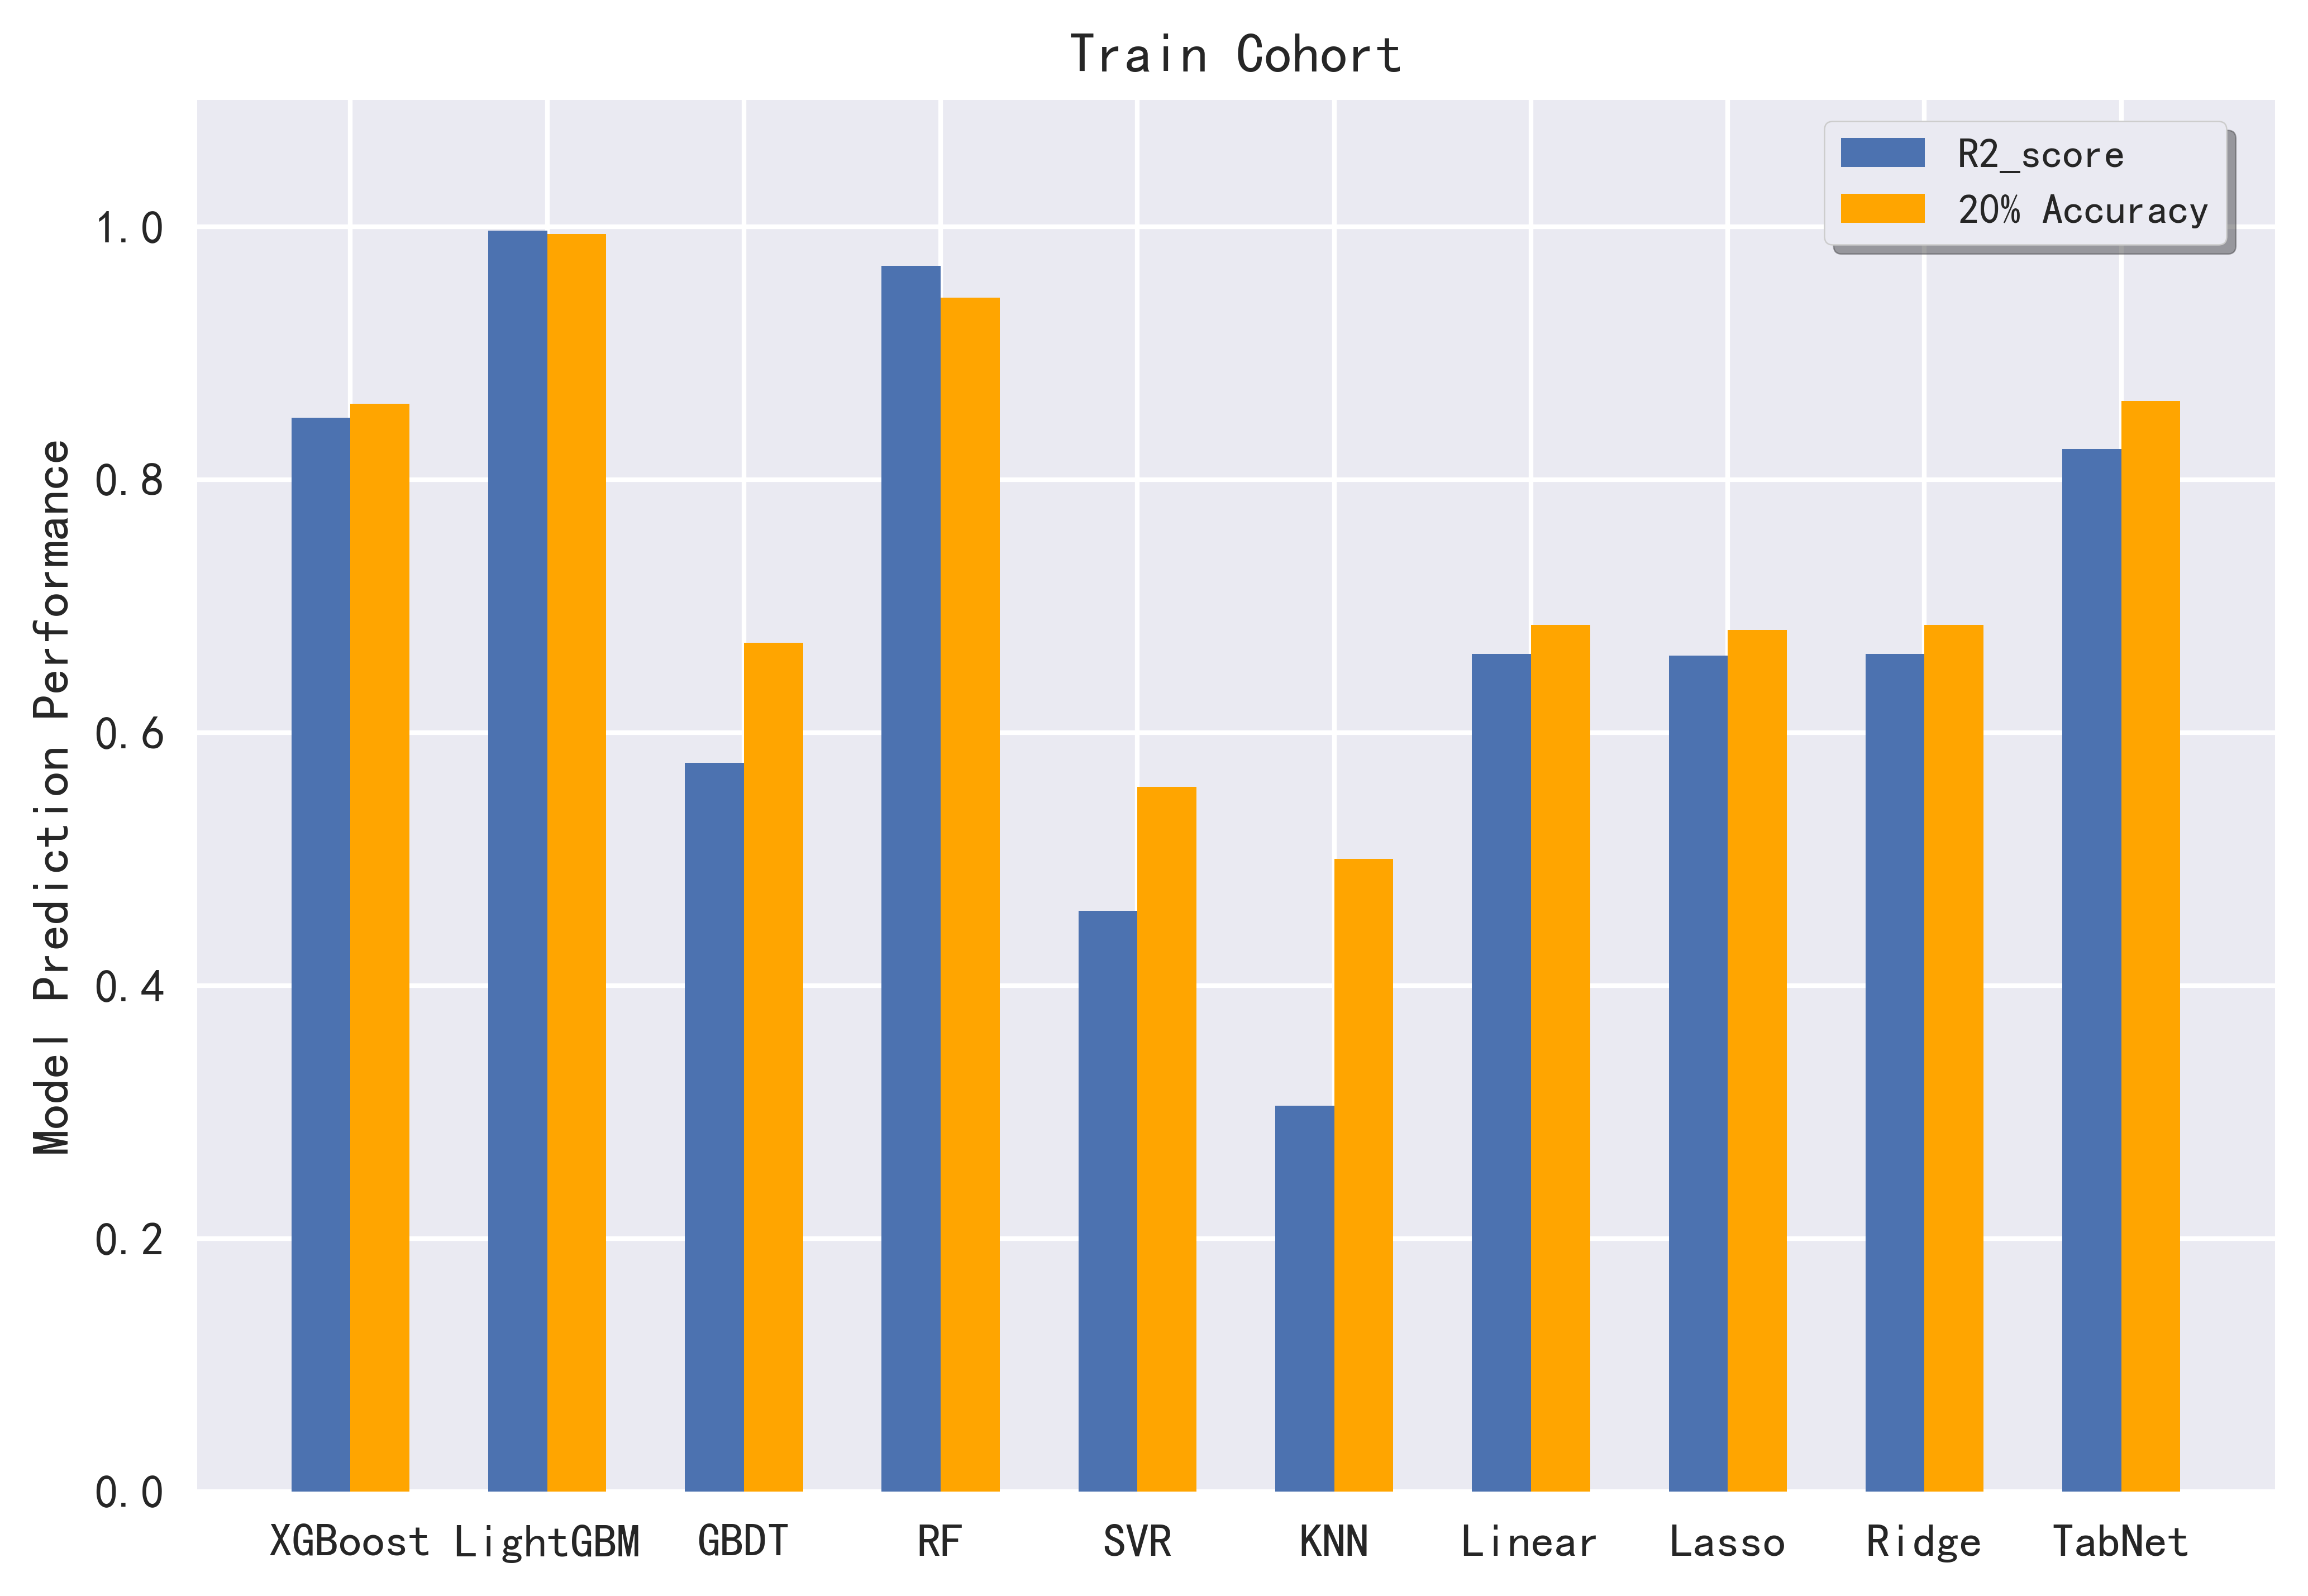

In [305]:
R2_l = [round(np.mean(v),3) for v in result_r2_train.values()]
per20_l = [round(np.mean(v),3) for v in train_acc.values()]
 
bar_width = 0.3
index_R2 = np.arange(len(model_list)) 
index_per20 = index_R2 + bar_width 
 
plt.bar(index_R2, height=R2_l, width=bar_width, label='R2_score')
plt.bar(index_per20, height=per20_l, width=bar_width, label='20% Accuracy',color='orange')
 
plt.legend()
plt.legend(loc='upper center', frameon='True',  bbox_to_anchor=(0.88,1.0), markerfirst=True, shadow='True', fontsize=9)
plt.xticks((index_R2 + index_per20)/2, model_list)
plt.ylim(0, 1.1)
plt.ylabel('Model Prediction Performance')
plt.title('Train Cohort')

# model_fig = plt.gcf()
# model_fig.savefig(r'./picture/model_performance_test.png') 
plt.show()

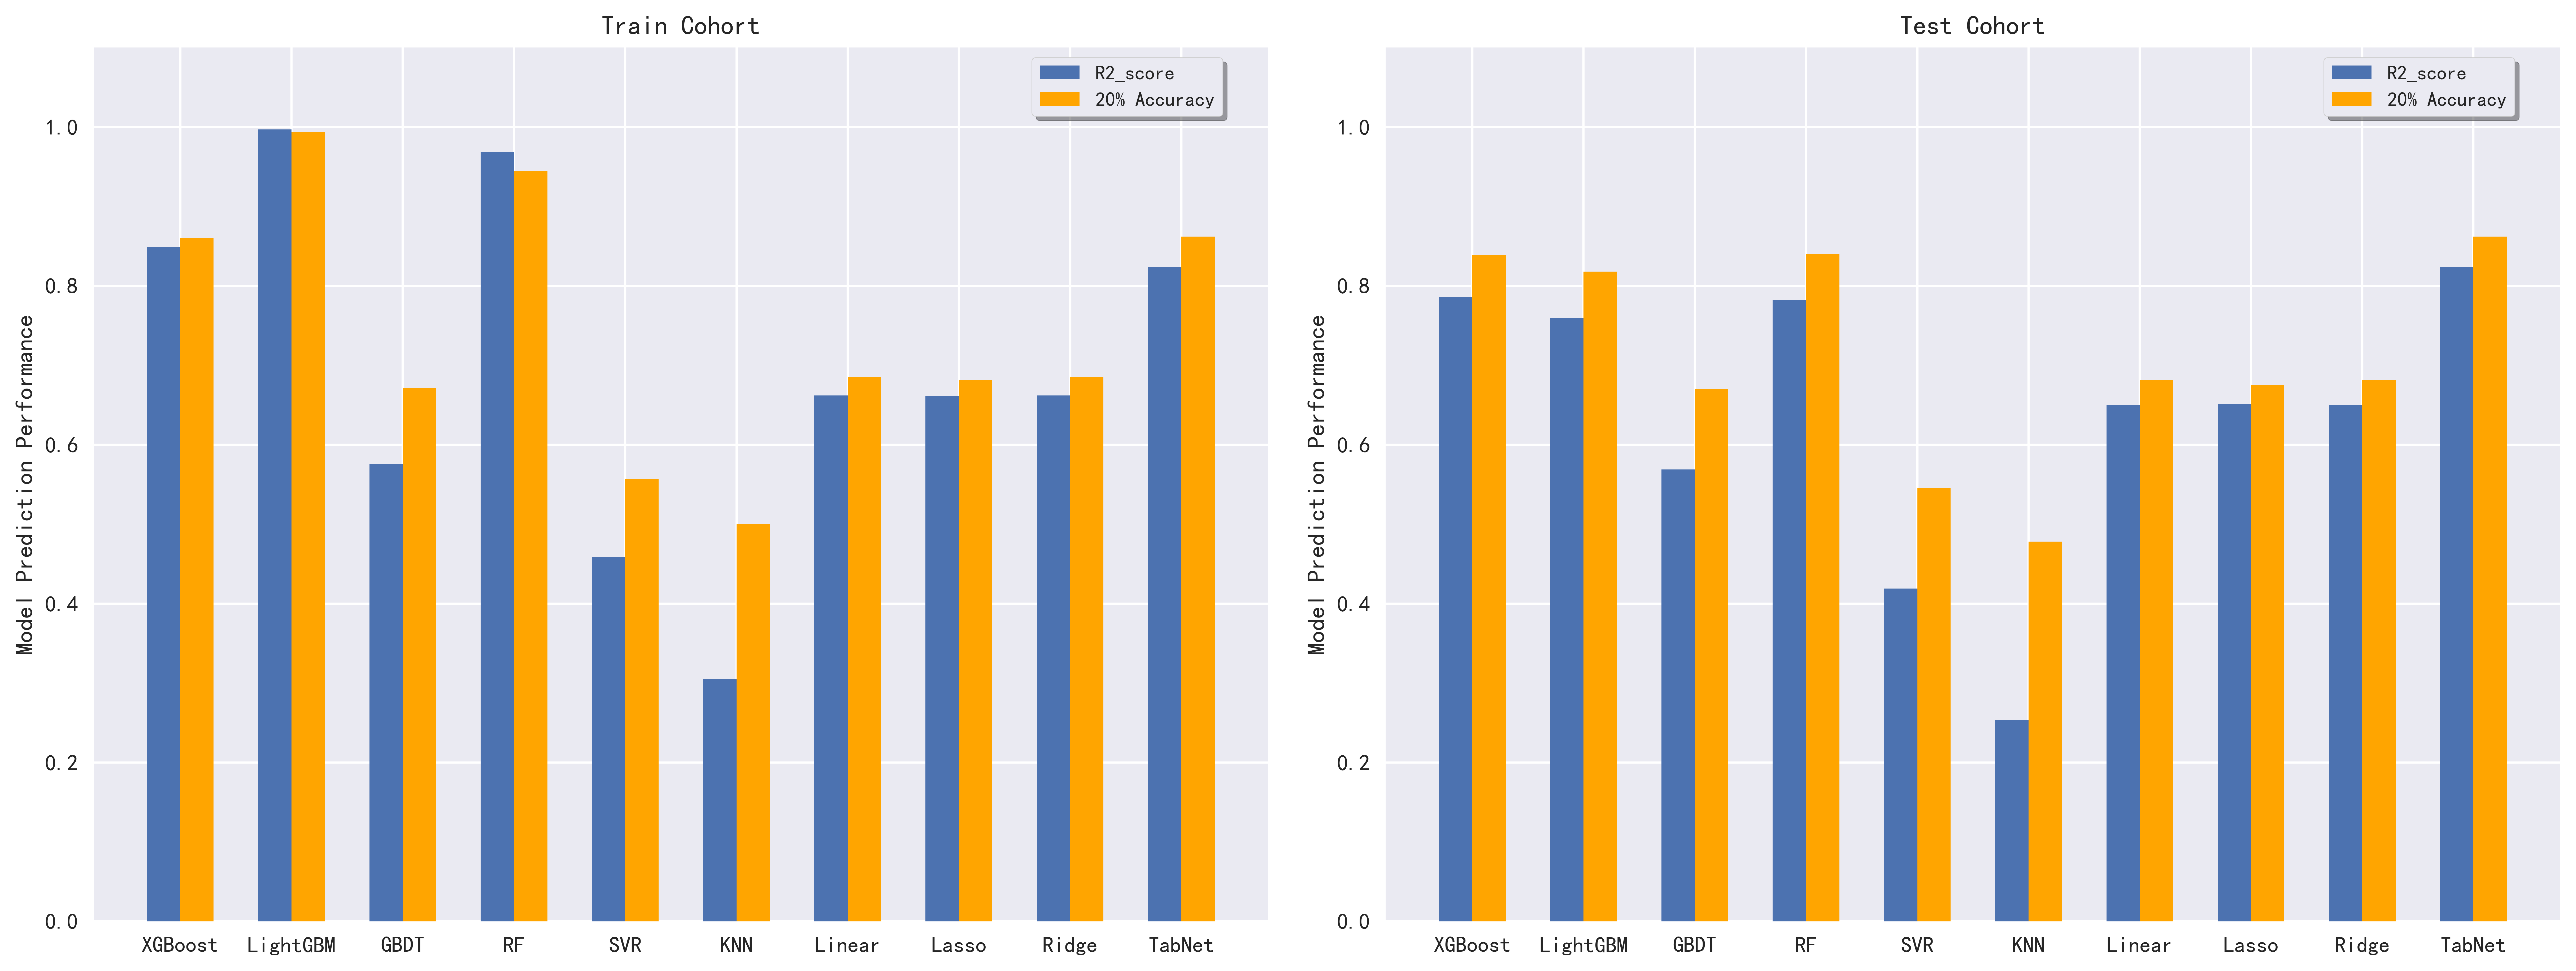

In [306]:
fig = plt.figure(figsize=(20,16))
# ========================================= 画图一 ============================================
plt.subplot(2,2,1)

R2_l = [round(np.mean(v),3) for v in result_r2_train.values()]
per20_l = [round(np.mean(v),3) for v in train_acc.values()]
 
bar_width = 0.3 
index_R2 = np.arange(len(model_list))
index_per20 = index_R2 + bar_width
 
plt.bar(index_R2, height=R2_l, width=bar_width, label='R2_score')
plt.bar(index_per20, height=per20_l, width=bar_width, label='20% Accuracy',color='orange')
 
plt.legend() 
plt.legend(loc='upper center', frameon='True',  bbox_to_anchor=(0.88,1.0), markerfirst=True, shadow='True', fontsize=9)
plt.xticks((index_R2 + index_per20)/2, model_list) 
plt.ylim(0, 1.1)
plt.ylabel('Model Prediction Performance')
plt.title('Train Cohort')

plt.subplots_adjust(wspace=0.1)
# ========================================= 画图二 ============================================
plt.subplot(2,2,2)

R2_l = [round(np.mean(v),3) for v in result_r2.values()]
per20_l = [round(np.mean(v),3) for v in test_acc.values()]
 
bar_width = 0.3 
index_R2 = np.arange(len(model_list)) 
index_per20 = index_R2 + bar_width
 
plt.bar(index_R2, height=R2_l, width=bar_width, label='R2_score')
plt.bar(index_per20, height=per20_l, width=bar_width, label='20% Accuracy',color='orange')
 
plt.legend()
plt.legend(loc='upper center', frameon='True',  bbox_to_anchor=(0.88,1.0), markerfirst=True, shadow='True', fontsize=9)
plt.xticks((index_R2 + index_per20)/2, model_list) 
plt.ylim(0, 1.1)
plt.ylabel('Model Prediction Performance') 
plt.title('Test Cohort')

# model_fig = plt.gcf()
# model_fig.savefig(r'./picture/model_performance_train_test.png') 
plt.show()

# box plot

In [307]:
test_acc

{'XGBoost': [0.8333, 0.8659, 0.8234, 0.8369, 0.8349],
 'LightGBM': [0.8065, 0.8525, 0.8042, 0.8119, 0.8157],
 'GBDT': [0.6609, 0.705, 0.6526, 0.6545, 0.6756],
 'RF': [0.8487, 0.8602, 0.8349, 0.8292, 0.8273],
 'SVR': [0.6494, 0.4713, 0.5777, 0.6334, 0.3954],
 'KNN': [0.4521, 0.5038, 0.4952, 0.501, 0.4357],
 'Linear': [0.6762, 0.7299, 0.6507, 0.6679, 0.6795],
 'Lasso': [0.6724, 0.728, 0.6411, 0.6603, 0.6718],
 'Ridge': [0.6762, 0.7299, 0.6507, 0.6679, 0.6795],
 'TabNet': [0.8544, 0.8908, 0.8407, 0.856, 0.8676]}

In [308]:
per20_acc = pd.DataFrame(data={'XGBoost':test_acc['XGBoost'],'LightGBM':test_acc['LightGBM'],
                               'GBDT':test_acc['GBDT'],'RF':test_acc['RF'],
                               'SVR':test_acc['SVR'],'KNN':test_acc['KNN'],
                               'Linear':test_acc['Linear'],'Lasso':test_acc['Lasso'],
                               'Ridge':test_acc['Ridge'],'TabNet':test_acc['TabNet']})

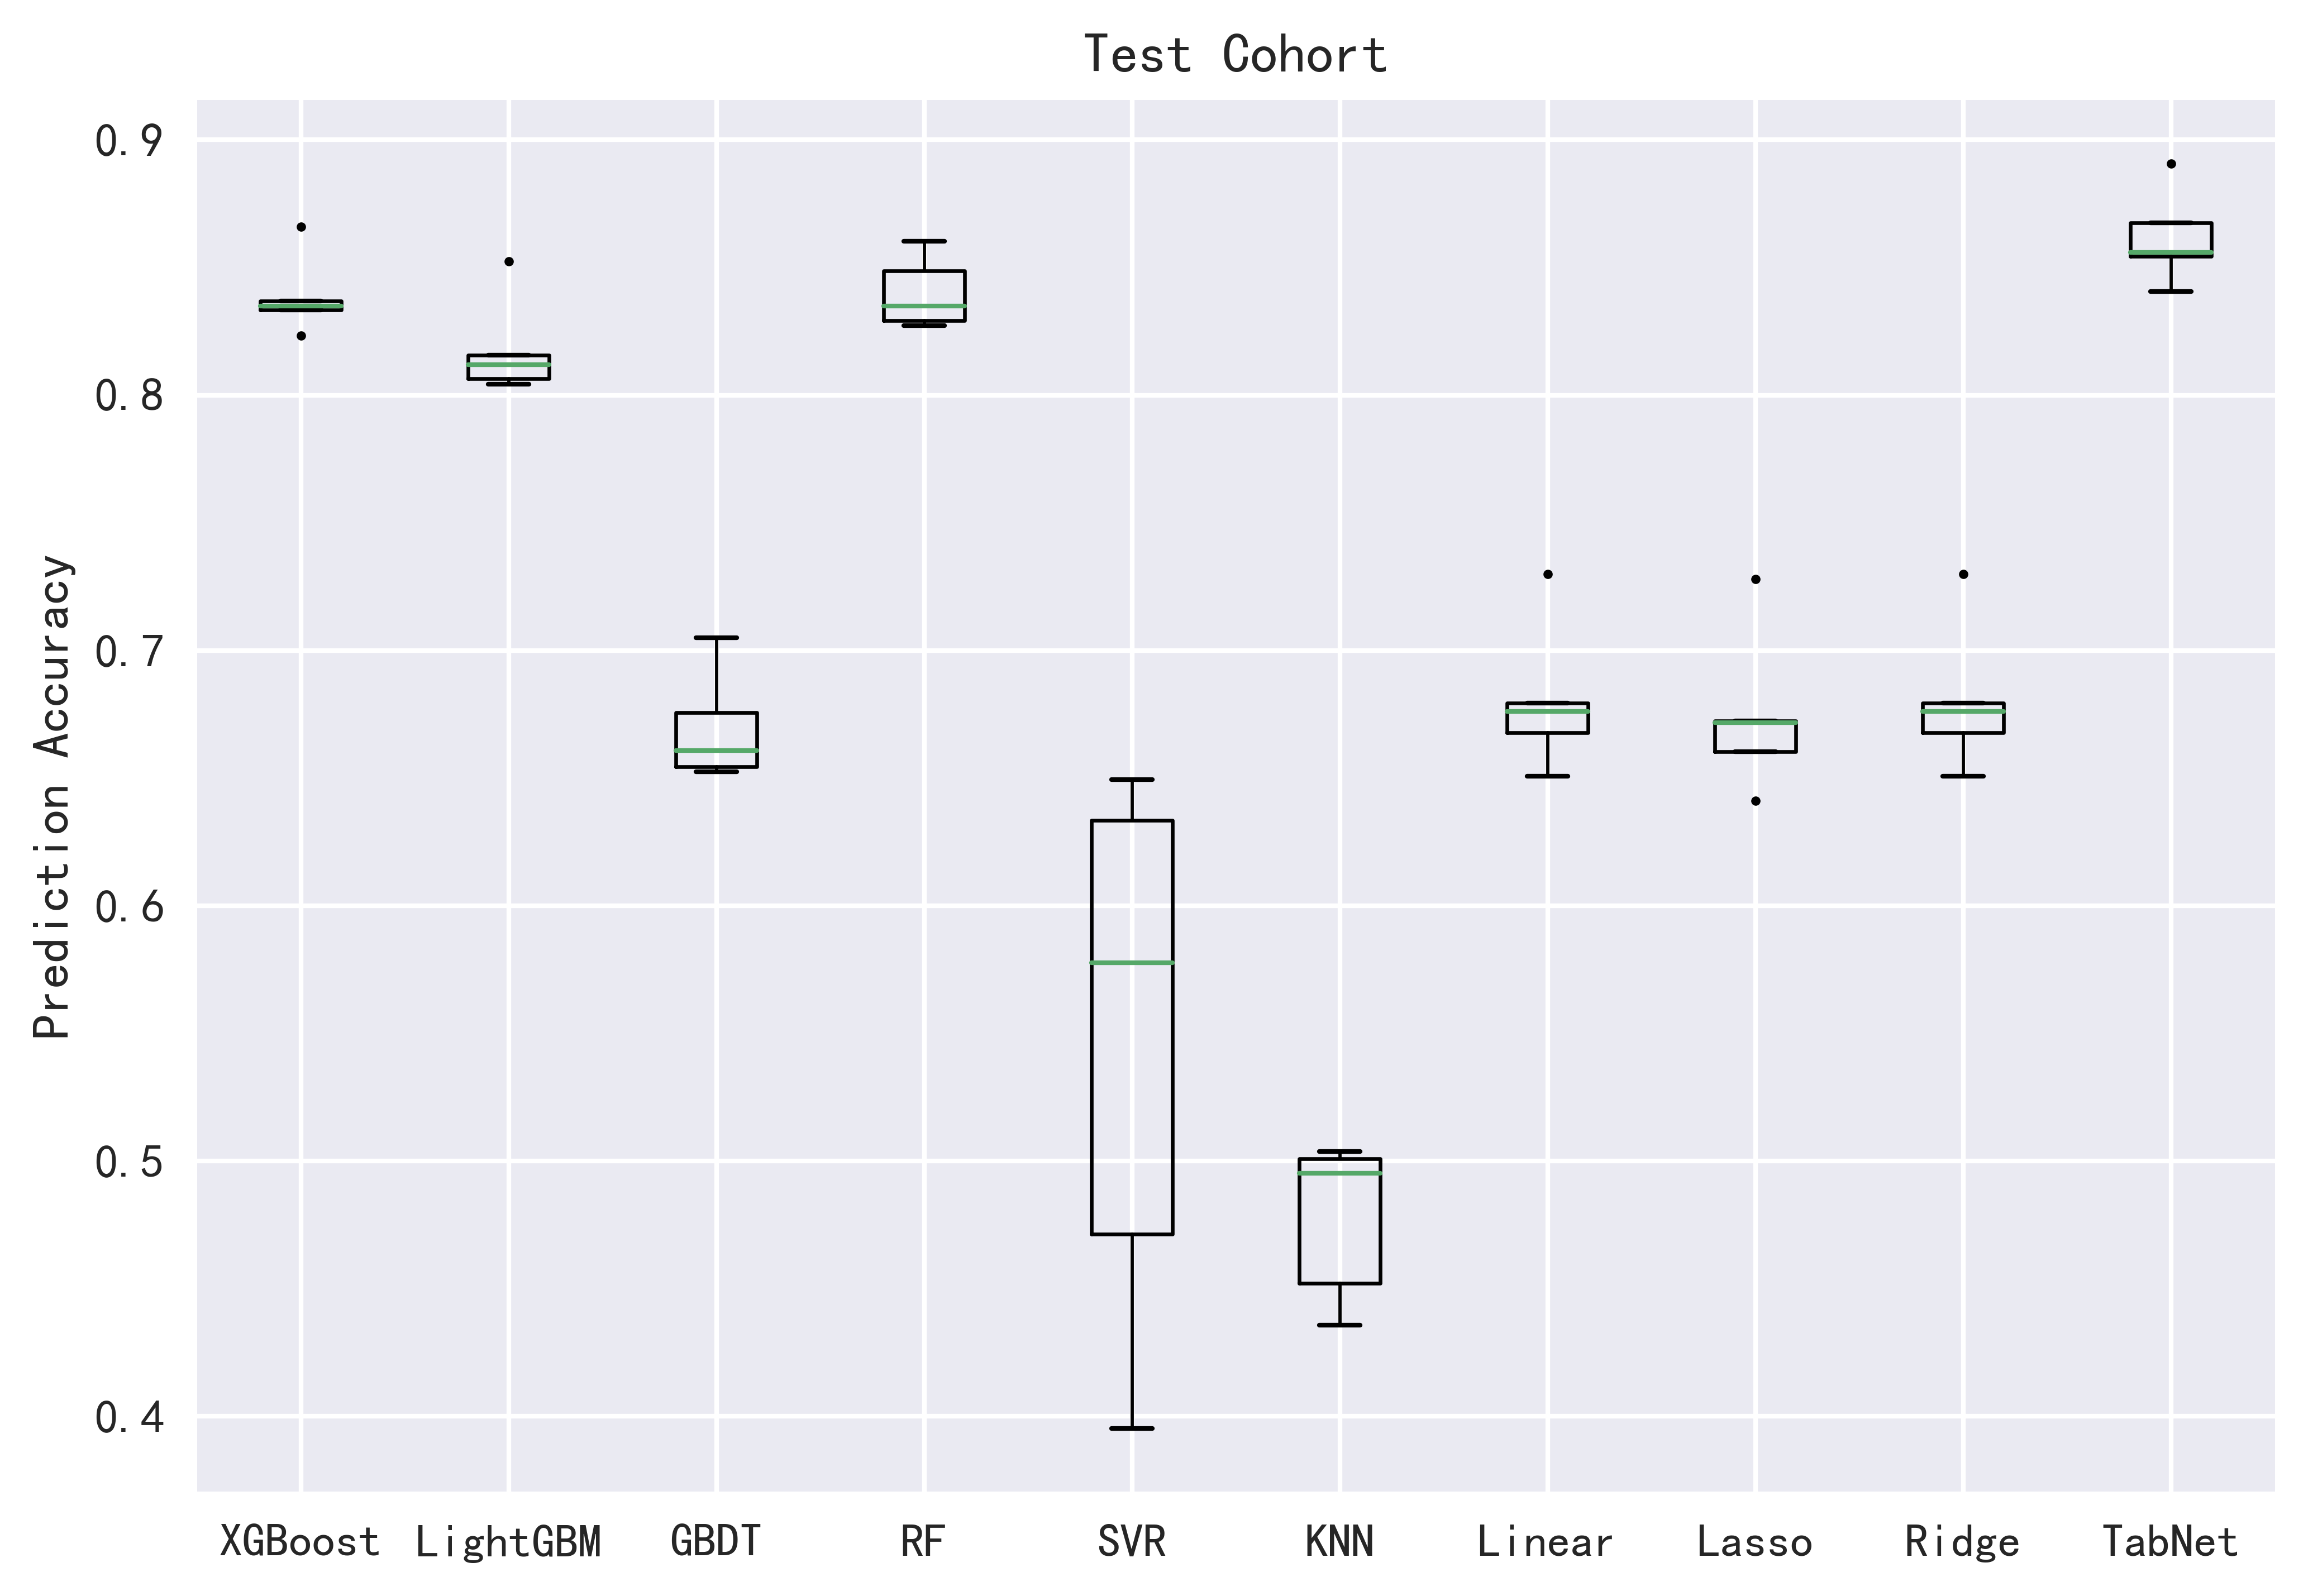

In [311]:
plt.boxplot(per20_acc,labels=per20_acc.columns,widths=0.39,
            flierprops={'marker':'o','markersize':1},
            whiskerprops={'Linewidth':0.7},
            boxprops={'Linewidth':0.8}
           )
plt.title('Test Cohort')
plt.ylabel('Prediction Accuracy')
# foo_fig = plt.gcf() # 'get current figure'
# foo_fig.savefig(r'./picture/boxplot.png',dpi=300)
plt.show()